# House price predict

In [2]:
import pandas as pd
import shap
# from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import catboost as cat
import numpy as np
from scipy.stats import spearmanr, pearsonr
from sklearn.svm import OneClassSVM
from keybert import KeyBERT
from sklearn.manifold import TSNE
from catboost import CatBoostRegressor
from catboost import Pool, metrics, cv
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## EDA

In [3]:
df = pd.read_csv("../data/train.csv")

In [4]:
df

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,...,40.709025,-73.939405,one room bushwick,Williamsburg,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206.0,1.0,1.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,...,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,...,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206.0,2.0,2.0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,...,40.738535,-74.000157,Designer's Apartment in HEART of NYC,West Village,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0


In [4]:
desc = df['description']

In [5]:
df['amenities']

0        {"Wireless Internet","Air conditioning",Kitche...
1        {"Wireless Internet","Air conditioning",Kitche...
2        {TV,"Cable TV","Wireless Internet","Air condit...
3        {TV,"Cable TV",Internet,"Wireless Internet",Ki...
4        {TV,Internet,"Wireless Internet","Air conditio...
                               ...                        
74106                                                   {}
74107    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
74108    {TV,Internet,"Wireless Internet","Air conditio...
74109    {TV,"Wireless Internet","Air conditioning",Kit...
74110    {TV,Internet,"Wireless Internet",Kitchen,"Free...
Name: amenities, Length: 74111, dtype: object

In [6]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [7]:
df.dtypes

id                          int64
log_price                 float64
property_type              object
room_type                  object
amenities                  object
accommodates                int64
bathrooms                 float64
bed_type                   object
cancellation_policy        object
cleaning_fee                 bool
city                       object
description                object
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
instant_bookable           object
last_review                object
latitude                  float64
longitude                 float64
name                       object
neighbourhood              object
number_of_reviews           int64
review_scores_rating      float64
thumbnail_url              object
zipcode                    object
bedrooms                  float64
beds                      float64
dtype: object

In [8]:
# Convert $ to numeric
df["log_price"] = df["log_price"].replace('[\$,]', '', regex=True).astype(float)
df["cleaning_fee"] = df["cleaning_fee"].replace('[\$,]', '', regex=True).astype(float)

In [9]:
# Convert % to numeric
df['host_response_rate'] = df['host_response_rate'].astype(str)


df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').apply(pd.to_numeric, errors='coerce')
# df['host_acceptance_rate'] = df['host_acceptance_rate'].str.rstrip('%').apply(pd.to_numeric, errors='coerce')

In [10]:
# Replacing similar values
df['city'] = df['city'].replace({'Washington, D.C.': 'Washington'})
df['city'] = df['city'].replace({'Washington ': 'Washington'})
# df['state'] = df['state'].replace({'Washington DC': 'DC'})
# df['smart_location'] = df['smart_location'].replace({'Washington, D.C., DC': 'Washington, DC',
#                                'Washington , DC' : 'Washington, DC'})

In [ ]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

    ## Text processing

In [11]:
df

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,1.0,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,1.0,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,1.0,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,1.0,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,1.0,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,0.0,...,40.709025,-73.939405,one room bushwick,Williamsburg,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206.0,1.0,1.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,1.0,...,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,1.0,...,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206.0,2.0,2.0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,1.0,...,40.738535,-74.000157,Designer's Apartment in HEART of NYC,West Village,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0


In [12]:
cat = df.description.str.cat(sep=' ')

In [13]:
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(cat, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=20)
keys = [i[0] for i in keywords]
keys.remove('bedrooms')

ValueError: list.remove(x): x not in list

In [14]:
len(df.description)

74111

In [15]:
keywords = kw_model.extract_keywords(df.description[110], highlight=True)
keywords

Private bedroom with full size bed for one Cozy bedroom big enough for two with large closet Plenty of storage 
Quiet space with large kitchen and living room Full access bedroom space kitchen bathroom and roof Feel free to 
read book on the roof or catch tan Just overall be respectful will be available via call text will also leave list 
of recommendations to local restaurants and bars Feel free to call anytime Several restaurants and bars located on 
lewis ave which is block away Craft beer wine bars Enjoy French cuisine on Bedford ave or authentic italian on 
lewis Minutes away from the subway line B26 bus route directly in front apartment Minutes from downtown Walking 
distance to subway line Taxi services minutes away Several restaurants and bars located on lewis ave which is block
away Craft beer wine bars Enjoy French cuisine on Bedford ave or authentic Itilian on lewis

[('restaurants', 0.4606),
 ('downtown', 0.3708),
 ('subway', 0.3365),
 ('bedford', 0.3362),
 ('bedroom', 0.326)]

In [16]:
keywords = []
for i in tqdm(range(len(df.description))):
    keys = kw_model.extract_keywords(df.description[i], keyphrase_ngram_range=(1, 1), stop_words='english', top_n=3)
    keys = [i[0] for i in keys]
    keywords.append(keys)

100%|██████████| 74111/74111 [32:08<00:00, 38.43it/s]  


In [17]:
keywords

[['brownstone', 'manhattan', 'brooklyn'],
 ['manhattan', 'hudson', 'apartment'],
 ['apartment', 'backyard', 'neighborhood'],
 ['central', 'superbowl', 'city'],
 ['columbia', 'metro', 'city'],
 ['san', 'sf', 'francisco'],
 ['beach', 'cafe', 'restaurants'],
 ['downtown', 'la', 'condo'],
 ['garden', 'kitchen', 'patio'],
 ['tenants', '安全宁静的街区', '电话请在太平洋时间早上9点至晚上7点之间'],
 ['manhattan', 'bedroom', 'soho'],
 ['beach', 'bedroom', 'garage'],
 ['rent', 'apartment', 'riviera'],
 ['dc', 'st', 'bedroom'],
 ['bedroom', 'apartment', 'beach'],
 ['airbnb', 'renting', 'apartment'],
 ['milwaukee', 'wicker', 'neighborhood'],
 ['mall', 'quincy', 'bus'],
 ['apartment', 'manhattan', 'nyc'],
 ['brooklyn', 'manhattan', 'bedroom'],
 ['bedroom', 'residential', 'la'],
 ['manhattan', 'brooklyn', 'york'],
 ['la', 'place', 'broadway'],
 ['ventura', 'downtown', 'bedroom'],
 ['bedroom', 'apartment', 'room'],
 ['restaurants', 'bedrooms', 'kitchen'],
 ['melrose', 'sunset', 'apartment'],
 ['blvd', 'queens', 'hospital'],
 

In [18]:
def flatten(t):
    return [item for sublist in t for item in sublist]


In [19]:
key_list = flatten(keywords)

In [20]:
len(key_list)

222028

In [21]:
unique_keys = set(key_list)

In [22]:
len(unique_keys)

6262

In [23]:
key_columns = list(unique_keys)  # Convert the set to a list

key_rows = []
for i in desc:
    tmp_list = []
    for key in unique_keys:
        try:
            if key in i:
                tmp_list.append(1)
            else:
                tmp_list.append(0)
        except TypeError:
            continue
    key_rows.append(tmp_list)

In [51]:
key_categorical = pd.DataFrame(data=key_rows, columns = key_columns)

In [52]:
key_categorical

,luggage,restauran,gramercy,轉車可達各地,goldengate,toliuca,公寓位於紐約曼哈頓第五大道110街東,restroom,redfin,capital,...,metropolitan,grocery,furry,超五星级的享受却是汽车旅馆的价格,carroll,7号地铁通宵运营,kips,alcatraz,pines,warm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74108,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
k = key_categorical.corrwith(df["log_price"], method='spearman').sort_values(ascending=False)

An input array is constant; the correlation coefficient is not defined.


In [42]:
column_names = k[k > 0.09].index.tolist()

In [47]:
column_names.remove('bedrooms')

ValueError: list.remove(x): x not in list

In [48]:
from pandas import DataFrame
from IPython.display import HTML
HTML(DataFrame(k).to_html())

,0
bedrooms,0.182999
views,0.151271
modern,0.143831
lux,0.138743
view,0.131216
dec,0.127056
families,0.125380
beds,0.122763
sq,0.120975
rooms,0.119892


In [54]:
key_categorical = key_categorical[column_names]

In [55]:
key_categorical.head(5)

,views,modern,lux,view,dec,families,beds,sq,rooms,master,...,ted,bedroom,bedroo,kids,sea,groups,ceiling,stain,high,ga
0,1,0,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,1,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [56]:
key_categorical.isnull().sum()

views         0
modern        0
lux           0
view          0
dec           0
families      0
beds          0
sq            0
rooms         0
master        0
heart         0
din           0
luxury        0
fl            0
sofa          0
fireplace     0
floor         0
design        0
appliances    0
baths         0
ted           0
bedroom       0
bedroo        0
kids          0
sea           0
groups        0
ceiling       0
stain         0
high          0
ga            0
dtype: int64

In [57]:
df = pd.concat([df, key_categorical], axis=1)

In [58]:
df

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,ted,bedroom,bedroo,kids,sea,groups,ceiling,stain,high,ga
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,1.0,...,0,1,1,0,0,0,0,0,0,0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,1.0,...,1,1,1,0,0,0,0,1,0,0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,1.0,...,1,0,0,0,0,0,1,0,1,1
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,1.0,...,1,0,0,0,0,0,0,0,0,0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,1.0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,0.0,...,0,0,0,0,0,0,0,0,0,0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,1.0,...,1,1,1,0,0,0,0,0,0,0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,1.0,...,1,0,0,0,0,0,0,0,0,0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,1.0,...,1,0,0,0,1,0,0,0,0,0


In [59]:
# Drop single and text values
cat_list = ['description', 'first_review', 'zipcode', 'thumbnail_url', 'neighbourhood', 'name',
            'longitude', 'latitude', 'last_review']
df = df.drop(cat_list, axis=1)

In [60]:
df

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,ted,bedroom,bedroo,kids,sea,groups,ceiling,stain,high,ga
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,1.0,...,0,1,1,0,0,0,0,0,0,0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,1.0,...,1,1,1,0,0,0,0,1,0,0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,1.0,...,1,0,0,0,0,0,1,0,1,1
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,1.0,...,1,0,0,0,0,0,0,0,0,0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,1.0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,0.0,...,0,0,0,0,0,0,0,0,0,0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,1.0,...,1,1,1,0,0,0,0,0,0,0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,1.0,...,1,0,0,0,0,0,0,0,0,0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,1.0,...,1,0,0,0,1,0,0,0,0,0


ValueError: could not convert string to float: 'Apartment'

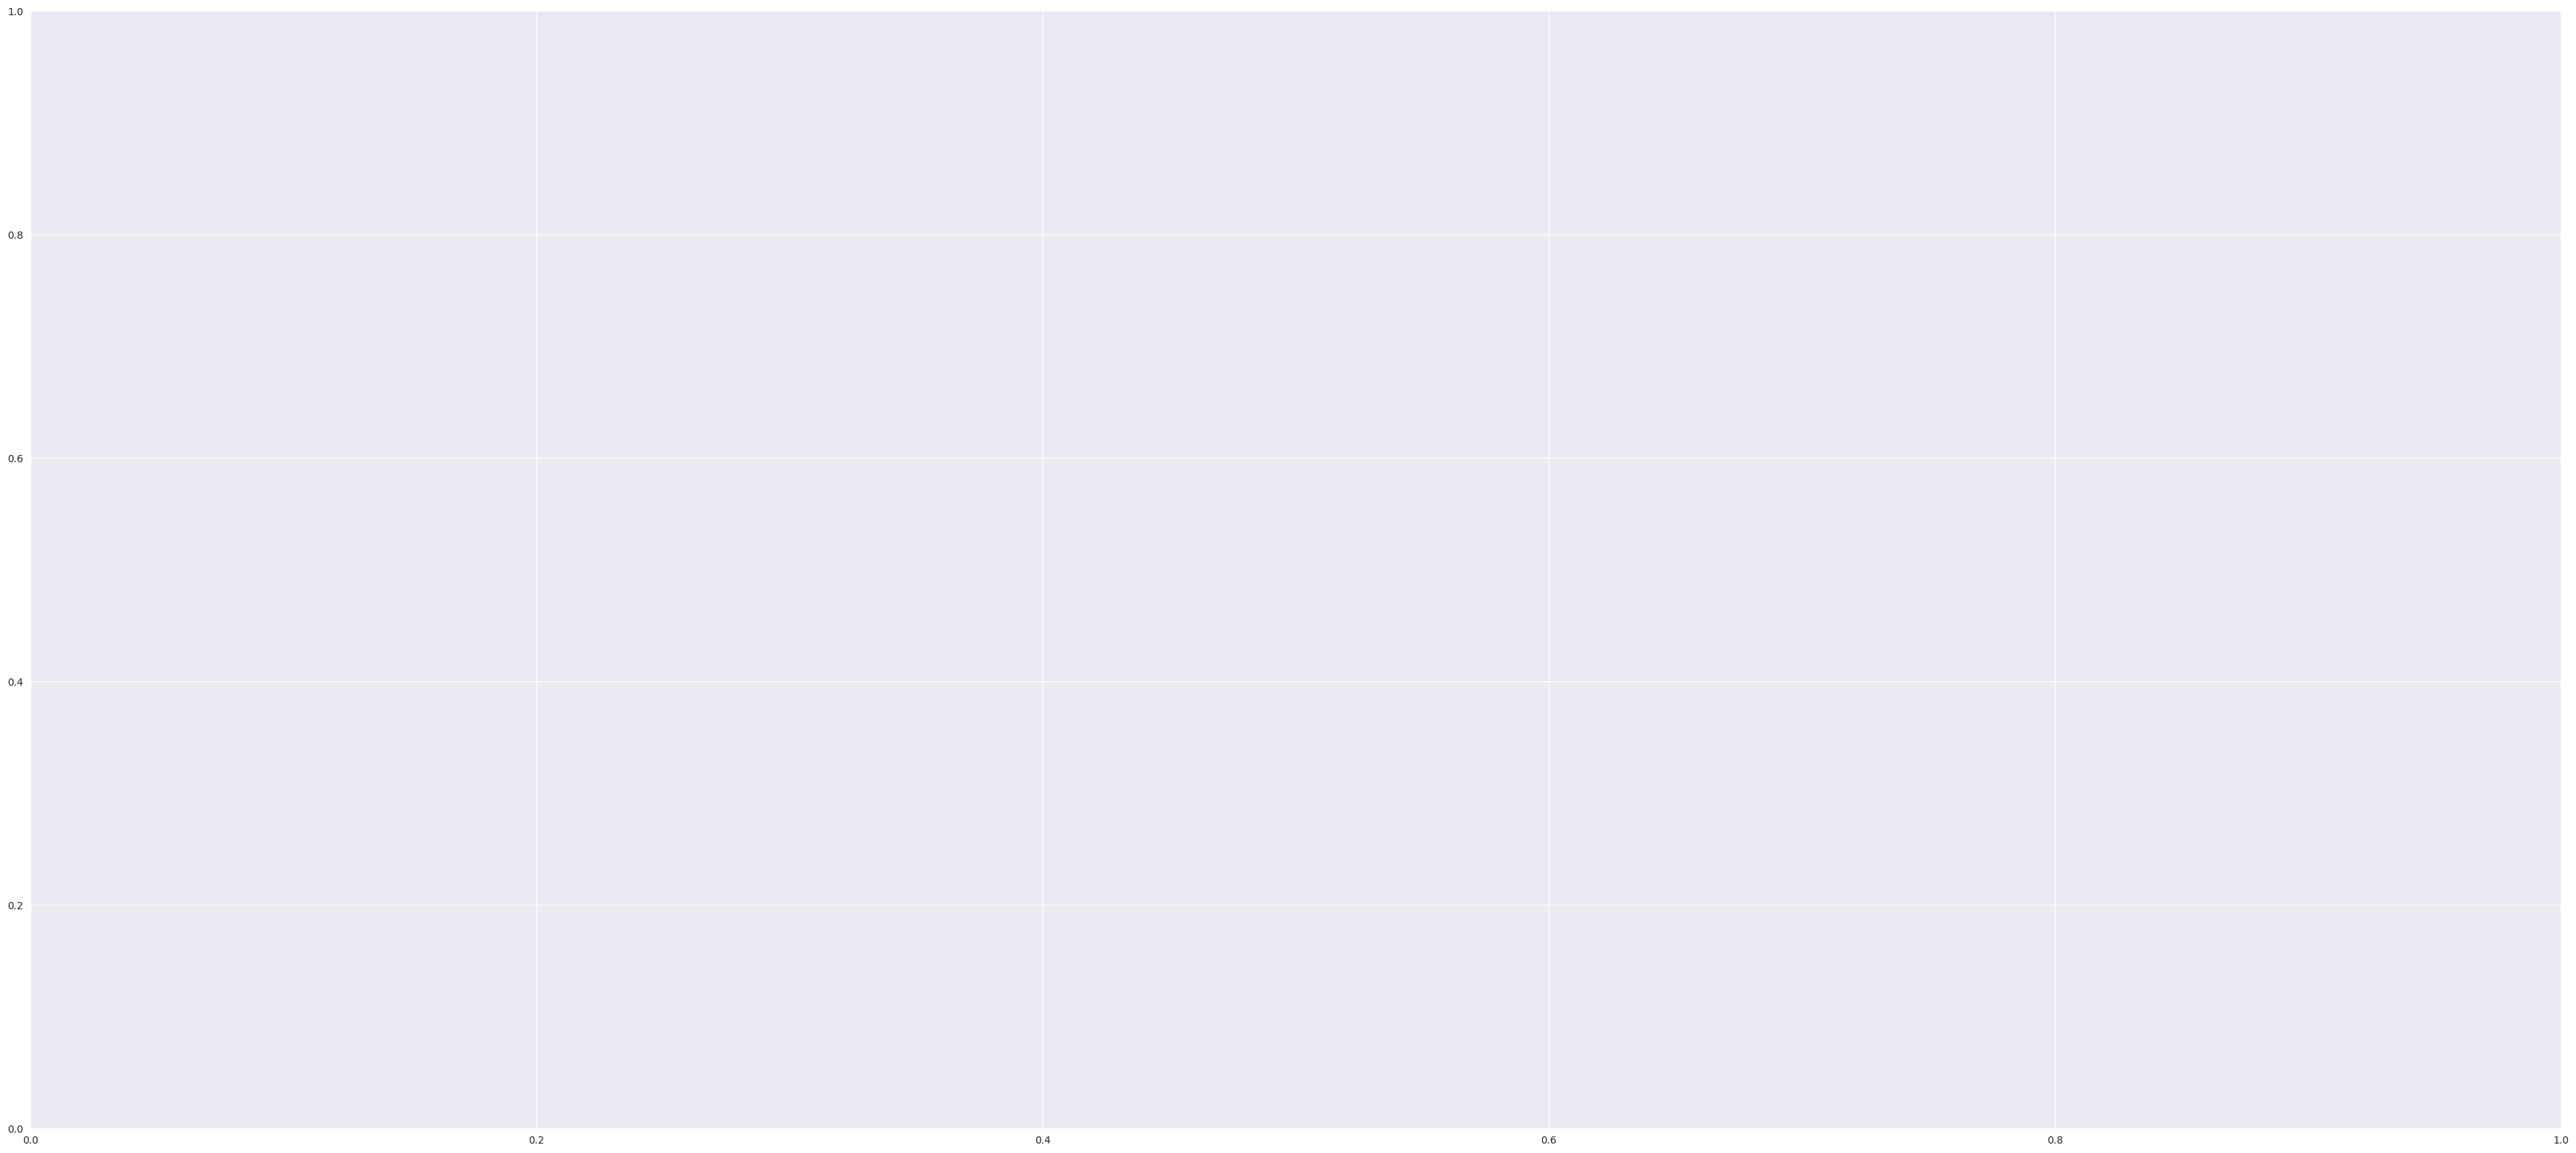

In [61]:
plt.subplots(figsize=(45,20))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True, linewidth=.5)

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'log_price'}>,
        <Axes: title={'center': 'accommodates'}>,
        <Axes: title={'center': 'bathrooms'}>,
        <Axes: title={'center': 'cleaning_fee'}>,
        <Axes: title={'center': 'host_response_rate'}>,
        <Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'review_scores_rating'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'sofa'}>,
        <Axes: title={'center': 'housekeeping'}>,
        <Axes: title={'center': 'appliances'}>,
        <Axes: title={'center': 'fireplace'}>,
        <Axes: title={'center': 'modern'}>,
        <Axes: title={'center': 'luxurious'}>],
       [<Axes: title={'center': 'van'}>,
        <Axes: title={'center': 'roof'}>,
        <Axes: title={'center': 'ceilings'}>,
        <Axes: title={'center': 'shared'}>,
        <Axes: title={'center': 'private'}>,
        <Ax

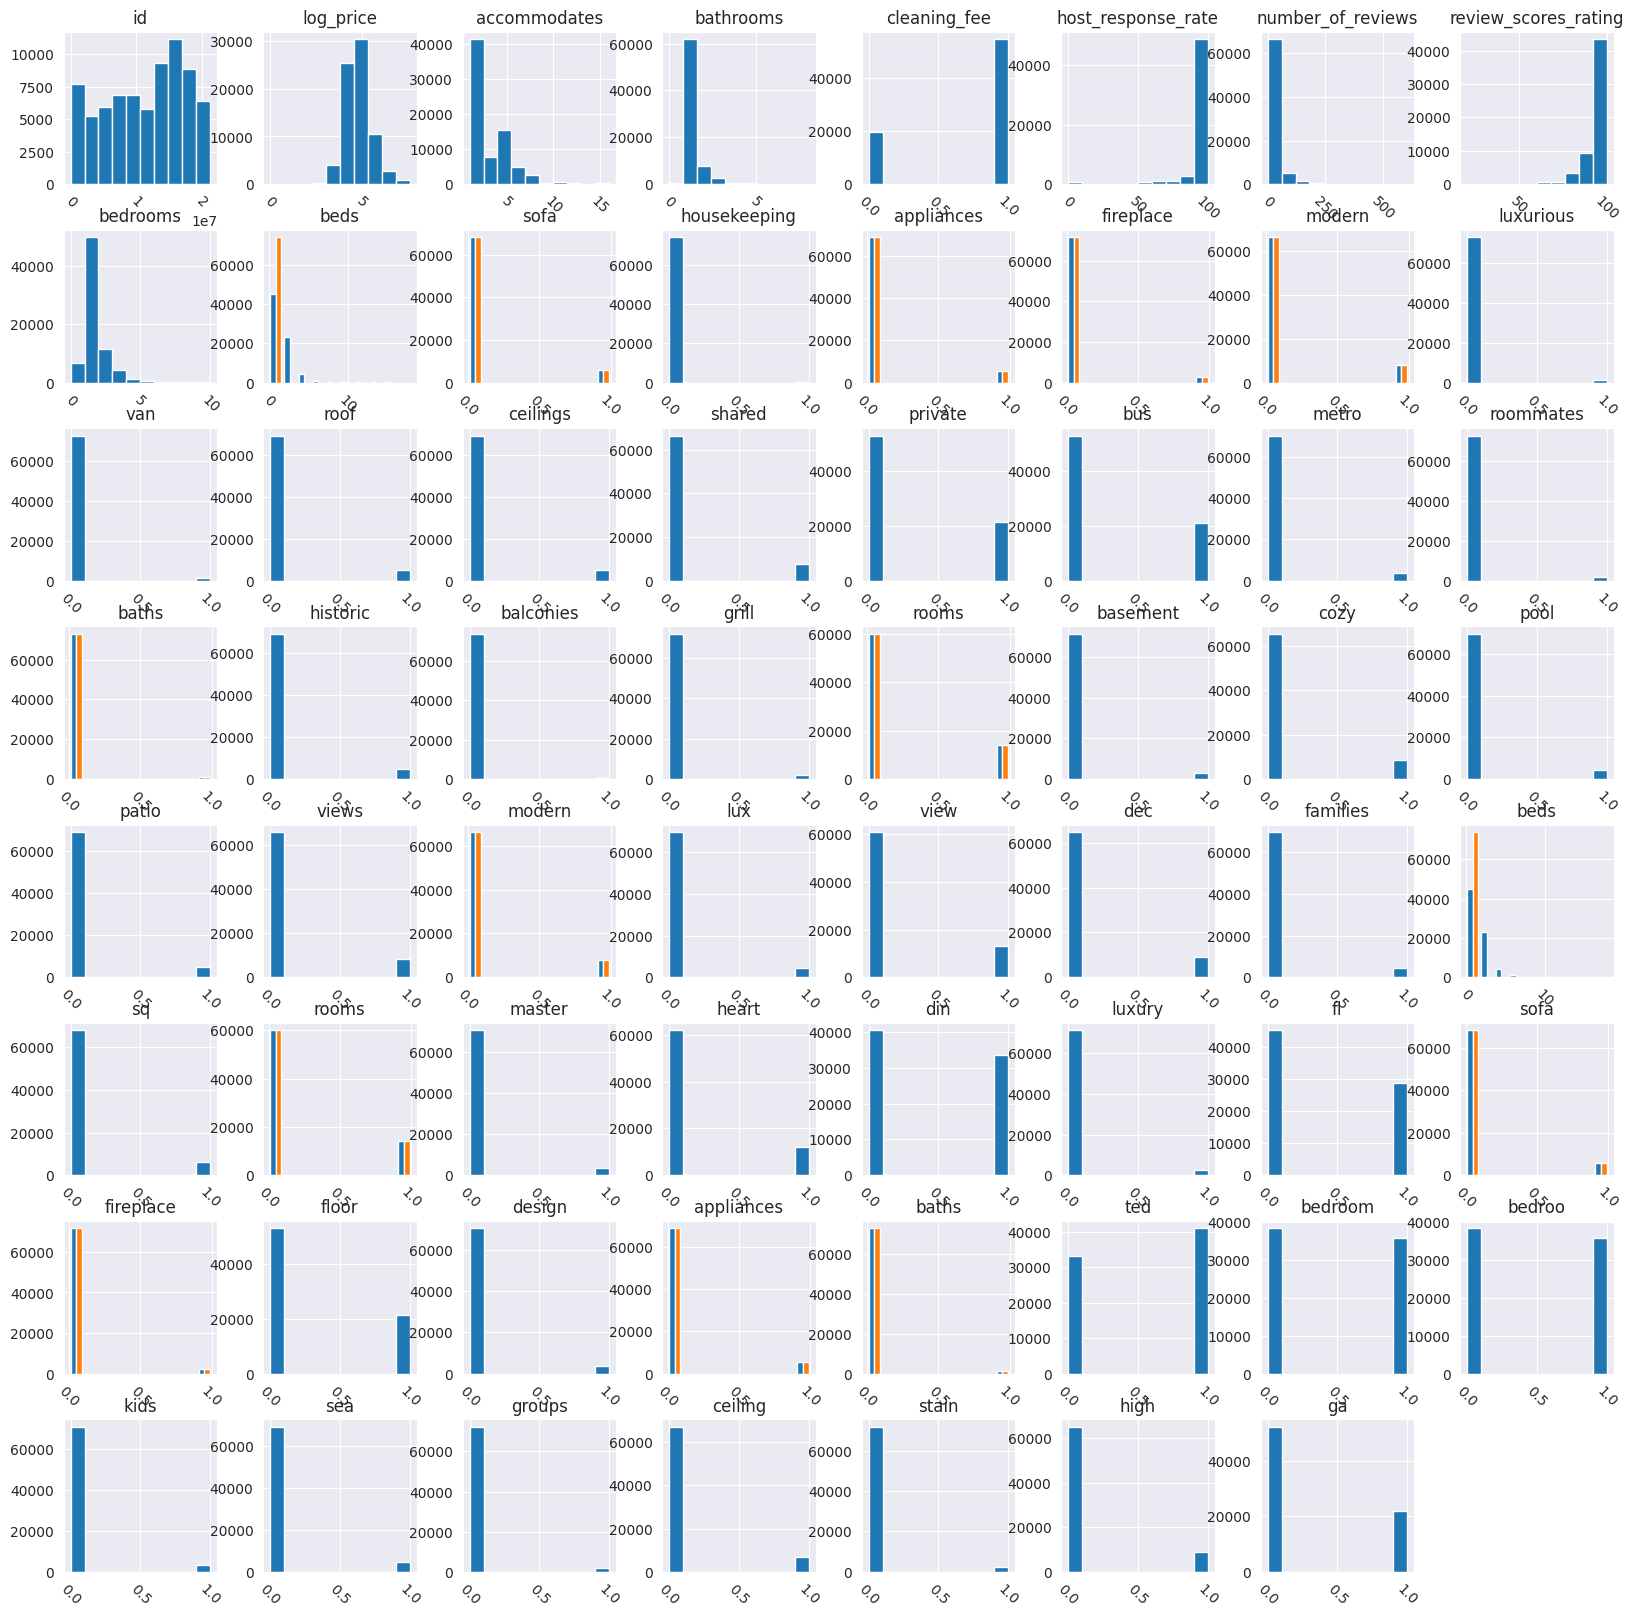

In [62]:
df.hist(figsize=(20,20), xrot=-45)

<Axes: xlabel='log_price'>

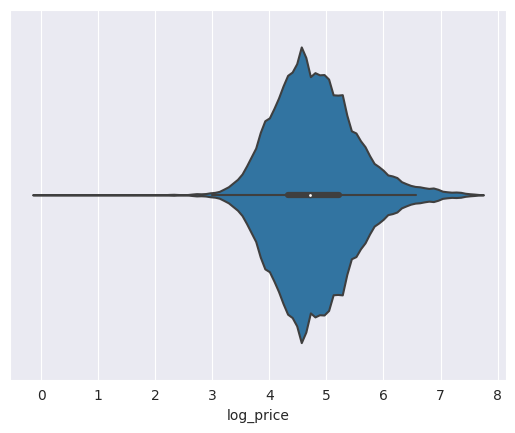

In [64]:
sns.violinplot(data=df, x='log_price')


## Data proccecing

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df['amenities'] = df['amenities'].apply(
    lambda x: [] if x == '{}' else sorted(list(map(lambda x: x.replace('"','') , x[1:-1].split(',') ) )  ))

unique_amenities = []
for item in df['amenities']:
    for i in item:
        if i not in unique_amenities:
            unique_amenities.append(i)
unique_amenities = sorted(unique_amenities)

amenities_columns = unique_amenities
amenities_rows = []
for i in df['amenities']:
    tmp_list = []
    for amenity in unique_amenities:
        if amenity in i:
            tmp_list.append(1)
        else:
            tmp_list.append(0)
    amenities_rows.append(tmp_list)
amenities_categorical = pd.DataFrame(data=amenities_rows, columns = amenities_columns)
amenities_categorical = amenities_categorical.dropna()
df = pd.concat([df, amenities_categorical], axis=1)
df = df.drop('amenities', axis=1)


In [ ]:
amenities_categorical

In [ ]:
df = pd.get_dummies(df)

In [ ]:
list_of_na = ['host_response_rate', 'host_acceptance_rate', 'review_scores_value',
              'reviews_per_month', 'cleaning_fee', 'bathrooms', 'bedrooms', 'beds',
              'bedrooms', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
              'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month']


correlation = {}
for col in list_of_na:
    na_list = []
    for i in range(1,10):
        df_knn = df
        imputer = KNNImputer(n_neighbors=i, weights='uniform', metric='nan_euclidean')
        imputer.fit(df_knn)
        Xtrans = imputer.transform(df_knn)
        df_reduced = pd.DataFrame(Xtrans)
        df_reduced.columns = df_knn.columns
        df_knn = df_reduced
        for column in list_of_na:
            df_knn[column] = df_knn[column].apply(lambda x: int(round(x)))

        df_knn['bathrooms'] = df_knn['bathrooms'].apply(lambda x: round(x * 2) / 2)
        na_list.append(spearmanr(df_knn.price, df_knn[[col]]).correlation)
    correlation[col] = na_list


In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(15,15))
axs = axs.ravel()
for i in range(0,14):
    axs[i].plot(range(1,10),list(correlation.values())[i],color='red', linestyle='dashed', marker='x',
    markerfacecolor='green', markersize=7)
    axs[i].set_title(list(correlation.keys())[i])


In [ ]:
impute = KNNImputer(n_neighbors=7)
df[['host_response_rate']] = impute.fit_transform(df[['host_response_rate']])
df[['host_acceptance_rate']] = impute.fit_transform(df[['host_acceptance_rate']])
df[['review_scores_value']] = impute.fit_transform(df[['review_scores_value']])
df[['reviews_per_month']] = impute.fit_transform(df[['reviews_per_month']])
df[['cleaning_fee']] = impute.fit_transform(df[['cleaning_fee']])
df[['bathrooms']] = impute.fit_transform(df[['bathrooms']])
df[['bedrooms']] = impute.fit_transform(df[['bedrooms']])
df[['beds']] = impute.fit_transform(df[['beds']])
df[['bedrooms']] = impute.fit_transform(df[['bedrooms']])
df[['review_scores_rating']] = impute.fit_transform(df[['review_scores_rating']])
df[['review_scores_accuracy']] = impute.fit_transform(df[['review_scores_accuracy']])
df[['review_scores_cleanliness']] = impute.fit_transform(df[['review_scores_cleanliness']])
df[['review_scores_checkin']] = impute.fit_transform(df[['review_scores_checkin']])
df[['review_scores_communication']] = impute.fit_transform(df[['review_scores_communication']])
df[['review_scores_location']] = impute.fit_transform(df[['review_scores_location']])
df[['reviews_per_month']] = impute.fit_transform(df[['reviews_per_month']])

In [ ]:
df.isnull().sum()[0:50]

In [ ]:
df = df.dropna()

In [ ]:
df.info()

### Outliers detection

In [ ]:
plt.scatter(range(df.shape[0]), np.log(np.sort(df['price'].values)))
plt.xlabel('index')
plt.ylabel('price')
plt.title("Price distribution")
sns.despine()

In [ ]:
sns.distplot(np.log(df['price']))
plt.title("Distribution")
sns.despine()


In [ ]:
print("Skewness: %f" % np.log(df['price'].skew()))
print("Kurtosis: %f" % np.log(df['price'].kurt()))

In [ ]:
likely_cat = {}
for var in df.columns:
    likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold
likely_cat

In [ ]:
categ = df.loc[:, df.columns != 'number_of_reviews']
categ = categ.loc[: ,categ.columns != 'reviews_per_month']
categ = categ.loc[: ,categ.columns != 'cleaning_fee']


In [ ]:
print(categ.corrwith(df["price"], method='spearman').sort_values(ascending=False)[1:10])
print(categ.corrwith(df["price"], method='spearman').sort_values(ascending=False)[-10:-1])


In [ ]:
df[['number_of_reviews', 'reviews_per_month', 'cleaning_fee']].corrwith(df["price"], method='pearson').sort_values(ascending=False)

In [ ]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['price'].values.reshape(-1, 1))
xx = np.linspace(df['price'].min(), df['price'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r',
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('price')
plt.show()

In [ ]:
sns.regplot(x="price", y="bedrooms", data=df)
sns.despine()


In [ ]:
sns.regplot(x="price", y="accommodates", data=df)
sns.despine()

In [ ]:
sns.regplot(x="price", y="bathrooms", data=df)
sns.despine()

In [ ]:
sns.regplot(x="price", y="beds", data=df)
sns.despine()

In [ ]:
sns.regplot(x="price", y="cleaning_fee", data=df)
sns.despine()

In [ ]:
sns.regplot(x="price", y="guests_included", data=df)
sns.despine()

In [ ]:
df.boxplot(column=['price'] ,rot=45)

In [ ]:
df.boxplot(column=['cleaning_fee'] ,rot=45)

In [ ]:
df.boxplot(column=['beds'] ,rot=45)

In [ ]:
df.boxplot(column=['bathrooms'] ,rot=45)

In [ ]:
df = df.dropna()

In [ ]:
X = df.values
db = DBSCAN(eps=250, min_samples=9, metric='euclidean')
y_db = db.fit_predict(X)

In [ ]:
outlier_index = np.where(y_db == -1)
outlier_values = df.iloc[outlier_index]
outlier_values.shape

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(df)

plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1] , c=y_db, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
model = OneClassSVM(kernel = 'rbf', gamma = 0.00001, nu = 0.0001).fit(X)
y_pred = model.predict(X)

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(df)

plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1] , c=y_pred, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [ ]:
outlier_index = np.where(y_pred == -1)
outlier_values = df.iloc[outlier_index]
outlier_values.shape

In [ ]:
df = df.loc[df['price']<300]
df = df.loc[df['bedrooms']<6]
df = df.loc[df['bathrooms']<5]
df = df.loc[df['beds']<8]
df = df.loc[df['guests_included']<12]
df = df.loc[df['cleaning_fee']<160]
df.shape

## Models training

In [ ]:
df1 = df.iloc[:300]
X_val = df1.drop('price', axis=1)
y_val = df1['price']
df = df.iloc[300:]

In [ ]:
X, y = df.iloc[:, df.columns != 'price'].values, \
       df.iloc[:, df.columns == 'price'].values

In [ ]:
X_train, X_test, y_train, y_test = \
    model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
          'l2_leaf_reg':[3,1,5,10,100]}


model = CatBoostRegressor()
grid = GridSearchCV(estimator=model, param_grid = params, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

In [ ]:
grid.best_params_

In [ ]:
cat = CatBoostRegressor(iterations=100,
                          learning_rate=0.001,
                          depth=10,
                          l2_leaf_reg=100)
cat.fit(X_train, y_train)

In [ ]:
preds = cat.predict(X_test)
print(np.sqrt(mean_squared_error(preds, y_test)))
print(mean_absolute_error(preds, y_test))

In [ ]:
train_pool = Pool(X_train, y_train)
validate_pool = Pool(X_test, y_test)

In [ ]:
feature_importances = cat.get_feature_importance(train_pool)
feature_names = X_val.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))


In [ ]:
explainer = shap.Explainer(cat.predict, X_test)
shap_values = explainer(X_test)

In [ ]:
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, np.log(y_train))

In [ ]:
preds = np.exp(regr.predict(X_test))
print(np.sqrt(mean_squared_error(preds, y_test)))
print(mean_absolute_error(preds, y_test))

In [ ]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_val, plot_type="bar")


In [ ]:
params = {'max_depth':[3,1,2,6,4,5,7,8,9,10],
          'n_estimators':[250,100,500,1000],
          'eta':[0.03,0.001,0.01,0.1,0.2,0.3],
          'subsample':[0.1,0.3,0.5,100]}


model = XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid = params, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

In [ ]:
xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb.fit(X_train, y_train)



In [ ]:
preds = xgb.predict(X_test)
print(np.sqrt(mean_squared_error(preds, y_test)))
print(mean_absolute_error(preds, y_test))

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [ ]:
lgbm = LGBMRegressor(random_state=37)
lgbm.fit(X_train, y_train)

In [ ]:
preds = lgbm.predict(X_test)
print(np.sqrt(mean_squared_error(preds, y_test)))
print(mean_absolute_error(preds, y_test))

In [ ]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_val, plot_type="bar")

In [ ]:
from sklearn.ensemble import StackingRegressor

ensemble_model = StackingRegressor([
    ("catboost", cat),
    ("random forest", regr),
    ('xgboost', xgb),
    ('lightgbm', lgbm)

], final_estimator=XGBRegressor())
ensemble_model.fit(X=X_train, y=y_train)
preds= ensemble_model.predict(X_test)
print(np.sqrt(mean_squared_error(preds, y_test)))
print(mean_absolute_error(preds, y_test))

In [ ]:
preds = lgbm.predict(X_val)
print(np.sqrt(mean_squared_error(preds, y_val)))
print(mean_absolute_error(preds, y_val))

#### Results board

| Model         | MAE| RMSE| Description                              |
| ------------- | -- | --- | ---------------------------------------- |
| CatBoost      | 66 | 109 | with auto categorical features           |
| Catboost      | 77 | 150 | with minimal preprocessing               |
| Random Forest | 57 | 130 | with minimal preprocessing               |
| CatBoost      | 44 | 57  | with deleted outliers and LabelBinarizer |
| Random Forest | 33 | 44  | with deleted outliers and LabelBinarizer |
| CatBoost      | 44 | 57  | with deleted outliers and get dummies    |
| Random Forest | 32 | 44  | with deleted outliers and get dummies    |
| Random Forest | 31 | 44  | with deleted outliers and get dummies and text columns|
| XGBoost | 25 | 36| with deleted outliers and get dummies and text columns|
